# Cap√≠tulo 8 ‚Äì Detecci√≥n de Anomal√≠as con Autoencoders

En este cap√≠tulo se introduce el enfoque de **Autoencoders**, uno de los primeros modelos de **Deep Learning** aplicados a la detecci√≥n de anomal√≠as.  

Su principal fortaleza radica en que **aprenden una representaci√≥n comprimida (codificaci√≥n) de los datos normales y luego intentan reconstruirlos**.  
Cuando el modelo encuentra un dato an√≥malo ‚Äîalgo que no encaja en el patr√≥n aprendido‚Äî el **error de reconstrucci√≥n** tiende a ser mayor, lo que permite identificar la anomal√≠a.

## Motivaci√≥n

La elecci√≥n de Autoencoders responde a varias razones:

- Modelan **relaciones no lineales complejas** en los datos.  
- No requieren etiquetas, √∫nicamente muestras representativas del comportamiento normal.  
- Permiten incorporar **estructuras temporales** (ventanas deslizantes o variantes recurrentes).  
- Funcionan como paso previo a arquitecturas m√°s avanzadas, como los **LSTM Autoencoders**.  
- Representan una primera aproximaci√≥n a las capacidades del **Deep Learning** en el campo de la detecci√≥n de anomal√≠as.

## Intuici√≥n

El Autoencoder es una red neuronal formada por dos componentes:

- **Encoder**: reduce la dimensionalidad de los datos, generando una representaci√≥n latente.  
- **Decoder**: reconstruye los datos originales a partir de dicha representaci√≥n.  

De forma intuitiva:

> Un Autoencoder aprende a copiar los datos normales. Cuando recibe un patr√≥n desconocido o an√≥malo, no consigue reconstruirlo con precisi√≥n y el error de reconstrucci√≥n se incrementa.

## Fundamento te√≥rico

El entrenamiento de un Autoencoder se plantea como la minimizaci√≥n del error de reconstrucci√≥n:

$$
\min_{\theta} L(x, g_{\theta}(f_{\theta}(x)))
$$

donde:

- $f_{\theta}(x)$: funci√≥n de codificaci√≥n (encoder).  
- $g_{\theta}(z)$: funci√≥n de decodificaci√≥n (decoder).  
- $L(\cdot)$: funci√≥n de p√©rdida, habitualmente el **MSE** (Mean Squared Error).  

El score de anomal√≠a para un punto $x$ se define como:

$$
s(x) = \|x - \hat{x}\|^2
$$

Si $s(x)$ supera un umbral definido, el punto se clasifica como an√≥malo.

## Funci√≥n de decisi√≥n y scores

- **Salida del modelo**: reconstrucci√≥n $\hat{x}$ de la entrada $x$.  
- **Score de anomal√≠a**: error de reconstrucci√≥n.  
  - Valores bajos ‚Üí dato normal.  
  - Valores altos ‚Üí potencial anomal√≠a.

## Par√°metros clave

- Dimensi√≥n del espacio latente.  
- N√∫mero de capas y neuronas en la red.  
- Funciones de activaci√≥n (ReLU, tanh, etc.).  
- Funci√≥n de p√©rdida (MSE, MAE o variantes robustas).  
- Regularizaci√≥n (dropout, weight decay, sparsity).  


## Implementaci√≥n de un Autoencoder b√°sico

A continuaci√≥n construiremos un Autoencoder sencillo y lo probaremos en distintos escenarios.  
El objetivo es ver de manera intuitiva:

- C√≥mo aprende a **reconstruir patrones normales**.  
- Qu√© ocurre cuando aparecen **anomal√≠as** que no encajan con esos patrones.  
- C√≥mo la **representaci√≥n latente** organiza la informaci√≥n.  


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

# Configuraci√≥n reproducible
rng = np.random.default_rng(42)
torch.manual_seed(42);

### Datos de partida: nube 2D

Comenzamos con un dataset muy simple:  
- Puntos normales formando una nube alrededor del centro.  
- Anomal√≠as dispersas m√°s alejadas.  

Esto permitir√° ver si el Autoencoder diferencia lo que aprendi√≥ a reconstruir de lo que nunca ha visto.


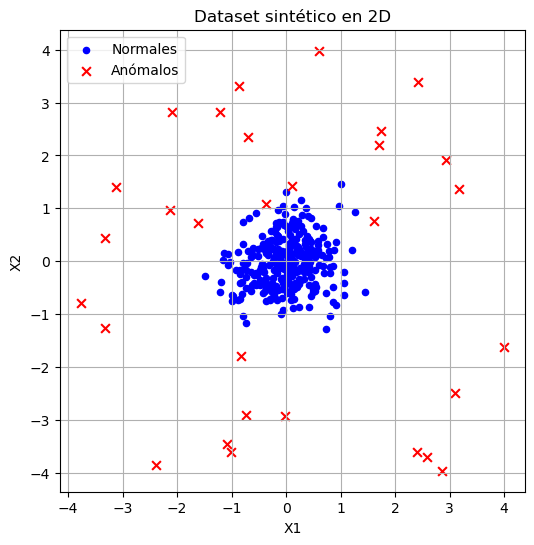

In [21]:
# Datos normales (gaussianos alrededor de 0,0)
X_norm = rng.normal(loc=0, scale=0.5, size=(300, 2))

# Anomal√≠as (distribuidas m√°s lejos)
X_anom = rng.uniform(low=-4, high=4, size=(30, 2))

# Conjunto completo
X = np.vstack([X_norm, X_anom])
y_true = np.hstack([np.zeros(len(X_norm)), np.ones(len(X_anom))])  # 0=normal, 1=an√≥malo

plt.figure(figsize=(6,6))
plt.scatter(X_norm[:,0], X_norm[:,1], c="blue", s=20, label="Normales")
plt.scatter(X_anom[:,0], X_anom[:,1], c="red", marker="x", s=40, label="An√≥malos")
plt.legend(); plt.title("Dataset sint√©tico en 2D"); plt.xlabel("X1"); plt.ylabel("X2"); plt.grid(True)
plt.show()


### Definici√≥n del Autoencoder

El modelo tendr√°:
- **Encoder**: reduce de 2 ‚Üí 1 dimensi√≥n.  
- **Decoder**: reconstruye de 1 ‚Üí 2 dimensiones.  


In [22]:
class SimpleAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(1, 2)
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

model = SimpleAE()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


### Entrenamiento

Entrenamos √∫nicamente con los datos normales para que el modelo aprenda a reproducir esa distribuci√≥n.  


In [23]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_norm)
X_tensor = torch.tensor(X_train, dtype=torch.float32)

for epoch in range(300):
    optimizer.zero_grad()
    recon = model(X_tensor)
    loss = criterion(recon, X_tensor)
    loss.backward()
    optimizer.step()


### Error de reconstrucci√≥n

Calculamos el error de reconstrucci√≥n en normales y anomal√≠as.  


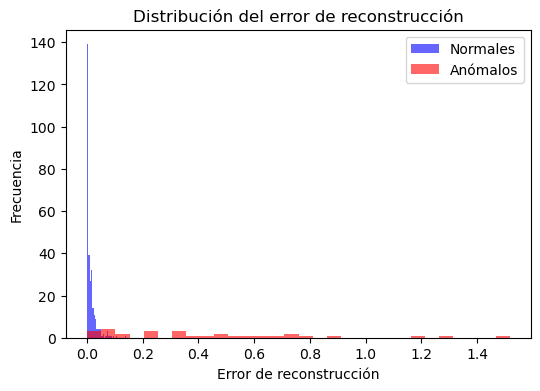

In [24]:
X_all = scaler.transform(X)
X_tensor_all = torch.tensor(X_all, dtype=torch.float32)

with torch.no_grad():
    recon_all = model(X_tensor_all)
    errors = torch.mean((X_tensor_all - recon_all)**2, dim=1).numpy()

plt.figure(figsize=(6,4))
plt.hist(errors[y_true==0], bins=30, alpha=0.6, label="Normales", color="blue")
plt.hist(errors[y_true==1], bins=30, alpha=0.6, label="An√≥malos", color="red")
plt.xlabel("Error de reconstrucci√≥n"); plt.ylabel("Frecuencia")
plt.title("Distribuci√≥n del error de reconstrucci√≥n")
plt.legend(); plt.show()


Los normales presentan errores bajos, mientras que las anomal√≠as quedan desplazadas hacia errores m√°s altos.  
El modelo no sabe reconstruir lo que nunca vio en el entrenamiento.


### Representaci√≥n latente

El encoder reduce los datos a una √∫nica variable.  
Podemos visualizar c√≥mo quedan organizados normales y an√≥malos en este espacio comprimido.


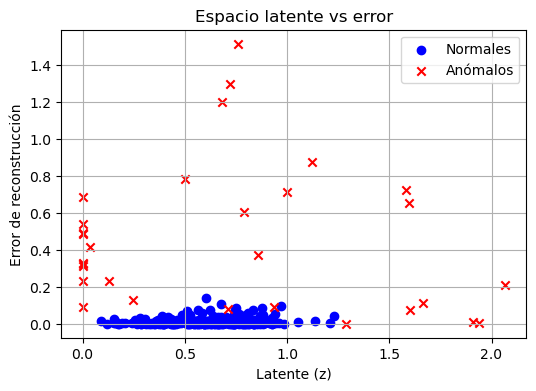

In [25]:
with torch.no_grad():
    z = model.encoder(X_tensor_all).numpy()

plt.figure(figsize=(6,4))
plt.scatter(z[y_true==0], errors[y_true==0], c="blue", label="Normales")
plt.scatter(z[y_true==1], errors[y_true==1], c="red", marker="x", label="An√≥malos")
plt.xlabel("Latente (z)"); plt.ylabel("Error de reconstrucci√≥n")
plt.title("Espacio latente vs error")
plt.legend(); plt.grid(True); plt.show()


Se observa c√≥mo los puntos normales forman una estructura compacta en el espacio latente,  
mientras que los an√≥malos aparecen m√°s dispersos y con errores mayores.


### Se√±ales temporales con fallo puntual

Otra forma de ver la utilidad de los Autoencoders es con series correlacionadas.  
Cuando las se√±ales se comportan de forma predecible entre s√≠, el modelo puede reconstruirlas bien.  
Si en un intervalo se rompe esa relaci√≥n, el error aumenta.


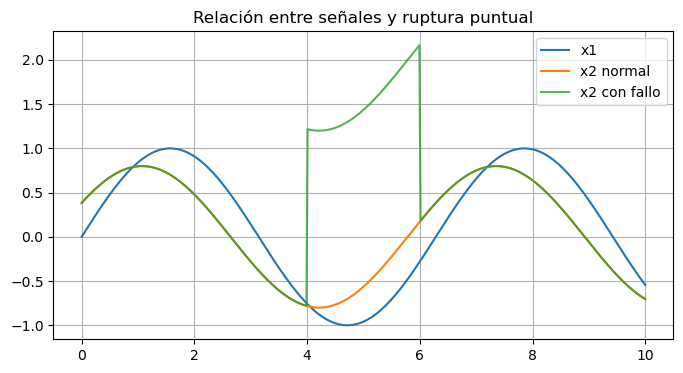

In [27]:
# Se√±ales correlacionadas
t = np.linspace(0, 10, 500)
x1 = np.sin(t)
x2 = np.sin(t + 0.5) * 0.8

# Introducimos un fallo en x2 durante un intervalo
x2_fault = x2.copy()
x2_fault[200:300] += 2.0

X_norm = np.vstack([x1, x2]).T
X_anom = np.vstack([x1, x2_fault]).T

plt.figure(figsize=(8,4))
plt.plot(t, x1, label="x1")
plt.plot(t, x2, label="x2 normal")
plt.plot(t, x2_fault, label="x2 con fallo", alpha=0.8)
plt.title("Relaci√≥n entre se√±ales y ruptura puntual")
plt.legend(); plt.grid(True); plt.show()


Entrenamos el Autoencoder sobre las se√±ales normales

In [29]:
class AE_Signals(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 2),
            nn.ReLU(),
            nn.Linear(2, 1)
        )
        self.decoder = nn.Sequential(
            nn.Linear(1, 2)
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

# Normalizamos y entrenamos
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_norm)

X_tensor = torch.tensor(X_train, dtype=torch.float32)
model = AE_Signals()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

for epoch in range(300):
    optimizer.zero_grad()
    recon = model(X_tensor)
    loss = criterion(recon, X_tensor)
    loss.backward()
    optimizer.step()


Evaluamos c√≥mo el autoencoder reconstruye tanto las se√±ales normales como las an√≥malas

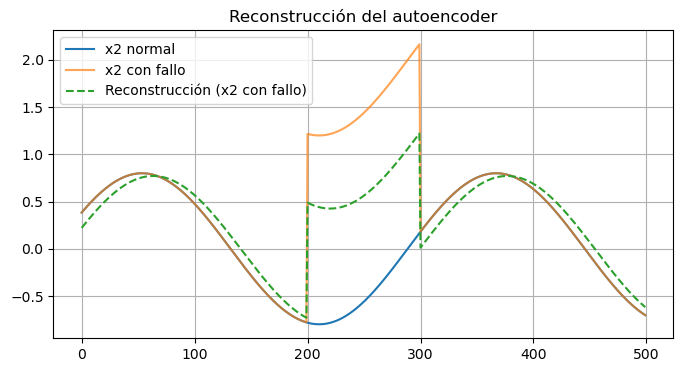

In [30]:
# Transformamos datos con fallo
X_all = np.vstack([X_norm, X_anom])
X_scaled = scaler.transform(X_all)
X_tensor_all = torch.tensor(X_scaled, dtype=torch.float32)

with torch.no_grad():
    recon_all = model(X_tensor_all).numpy()

# Reconstrucci√≥n de la parte con fallo
recon_norm = recon_all[:len(X_norm)]
recon_fault = recon_all[len(X_norm):]

plt.figure(figsize=(8,4))
plt.plot(x2, label="x2 normal")
plt.plot(x2_fault, label="x2 con fallo", alpha=0.7)
plt.plot(scaler.inverse_transform(recon_fault)[:,1], 
         label="Reconstrucci√≥n (x2 con fallo)", linestyle="--")
plt.title("Reconstrucci√≥n del autoencoder")
plt.legend(); plt.grid(True); plt.show()


El error deber√≠a permanecer bajo en los segmentos normales y subir en el intervalo del fallo.

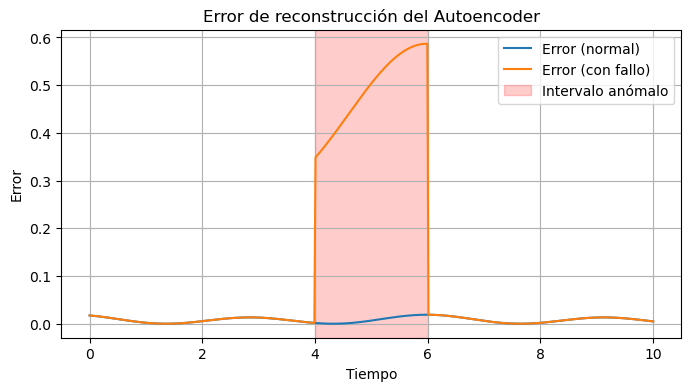

In [31]:
with torch.no_grad():
    errors = ((X_tensor_all.numpy() - recon_all)**2).mean(axis=1)

errors_norm = errors[:len(X_norm)]
errors_fault = errors[len(X_norm):]

plt.figure(figsize=(8,4))
plt.plot(t, errors_norm, label="Error (normal)")
plt.plot(t, errors_fault, label="Error (con fallo)")
plt.axvspan(t[200], t[300], color="red", alpha=0.2, label="Intervalo an√≥malo")
plt.title("Error de reconstrucci√≥n del Autoencoder")
plt.xlabel("Tiempo"); plt.ylabel("Error")
plt.legend(); plt.grid(True); plt.show()


En este escenario, el Autoencoder entrenado con las se√±ales normales no logra reconstruir bien el intervalo donde la correlaci√≥n se rompe, generando un error de reconstrucci√≥n elevado en ese segmento.


## Conclusi√≥n

Los Autoencoders ofrecen una forma eficaz de detectar anomal√≠as porque aprenden a **reconstruir patrones normales** a partir de un espacio latente comprimido.  
Cuando una observaci√≥n no encaja en lo aprendido, la reconstrucci√≥n se degrada y el error aumenta, lo que permite identificar el comportamiento an√≥malo.  

Este enfoque resulta especialmente √∫til cuando las variables presentan **correlaciones complejas** o cuando se trabaja con datos de alta dimensionalidad.  
Adem√°s, la posibilidad de extenderlos hacia variantes **recurrentes o convolucionales** abre la puerta a su aplicaci√≥n en contextos m√°s realistas, como series temporales multivariantes o se√±ales con estructura espacial.  

En definitiva, los Autoencoders marcan el paso de los m√©todos cl√°sicos a los modelos de **aprendizaje profundo**, mostrando c√≥mo las redes neuronales pueden capturar relaciones no lineales y servir como base para arquitecturas m√°s avanzadas en la detecci√≥n de anomal√≠as.


---

## Referencias

- Sakurada, Mayu, and Takehisa Yairi.  
  *Anomaly detection using autoencoders with nonlinear dimensionality reduction.* MLSDA, 2014.   

- Bui, H., et al.  
  *Predicting sector configuration transitions with autoencoder-based anomaly detection.* ICRAT, 2018.

- GitHub ‚Äì thomasdubdub.  
  *Autoencoder Anomaly Detection.* Disponible en: [https://github.com/thomasdubdub/autoencoder-anomaly-detection](https://github.com/thomasdubdub/autoencoder-anomaly-detection)  
  

Lo siguiente se retirar√° de este notebook, esta ah√≠ para probar el modelo

<Client: 'tcp://127.0.0.1:35669' processes=1 threads=1, memory=49.02 GiB>
üèÅ Ejecutando experimento en dataset: BATADAL
[‚úì] DATA cargado desde /home/pablo/TFG/MDF-ANOMALY-DETECTION/modelos/data/BATADAL/data.parquet (12938 filas)
   - Train: 8761 filas
   - Val:   2506 filas
   - Test:  1671 filas
Usando GPU (cuDF + CuPy) para este experimento.


Evaluaci√≥n en test: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:14<00:00, 14.61s/it]

Top 5 configuraciones (ordenadas por nab en validaci√≥n):


precision  recall    f1  roc_auc    nab  window_coverage  latent_dim  \
0       0.04   0.301  0.07    0.518 -0.274            0.306           8   

      lr  epochs  batch_size  
0  0.001       5          32

Resultados finales en TEST (top-k configs):


precision  recall     f1  roc_auc    nab  window_coverage  latent_dim  \
0      0.381   0.632  0.476    0.824 -0.786            0.532         8.0   

      lr  epochs  batch_size  
0  0.001    15.0        32.0

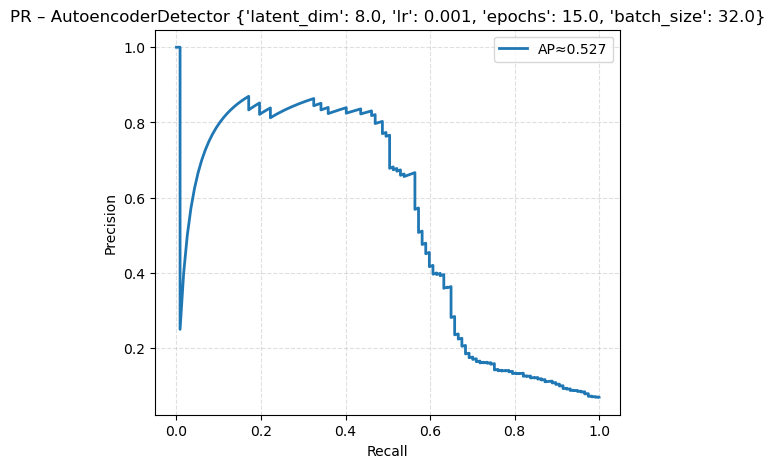

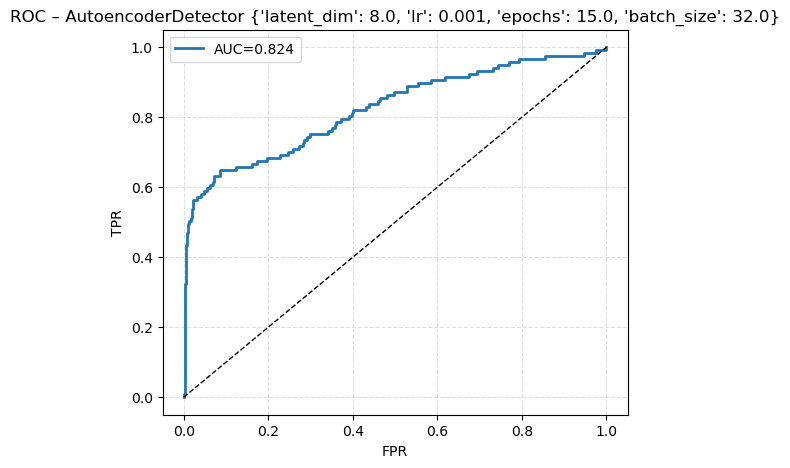

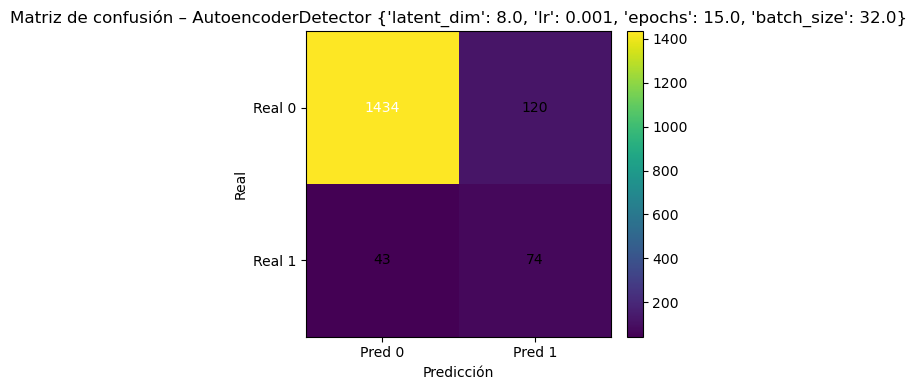

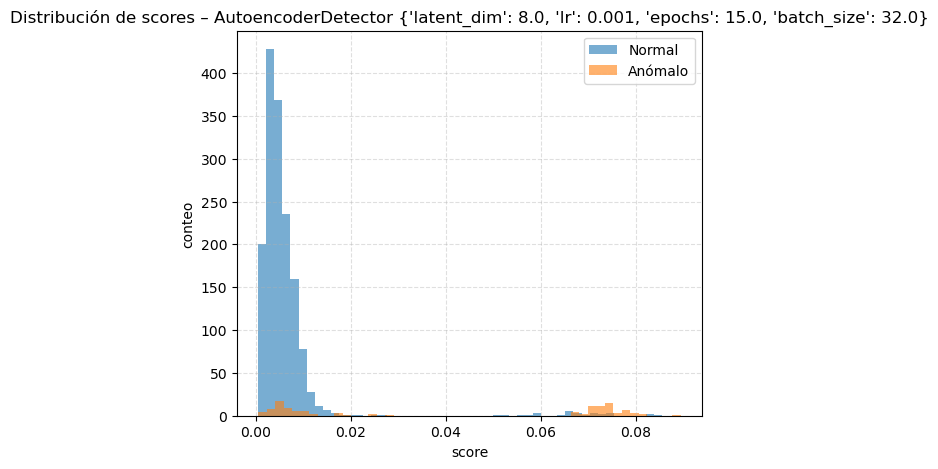

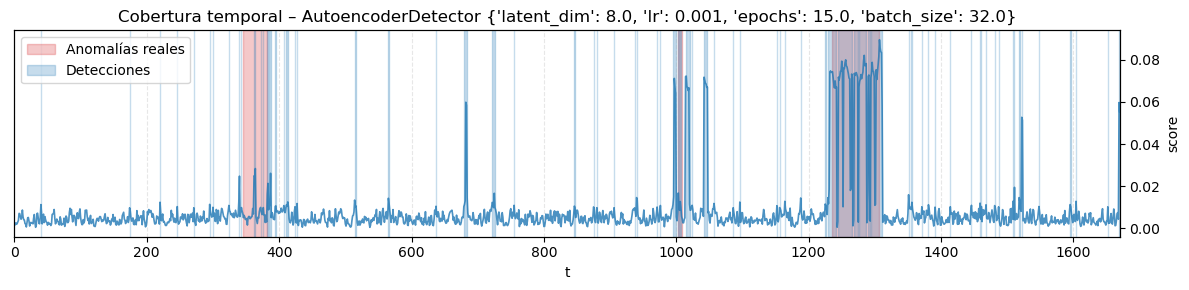

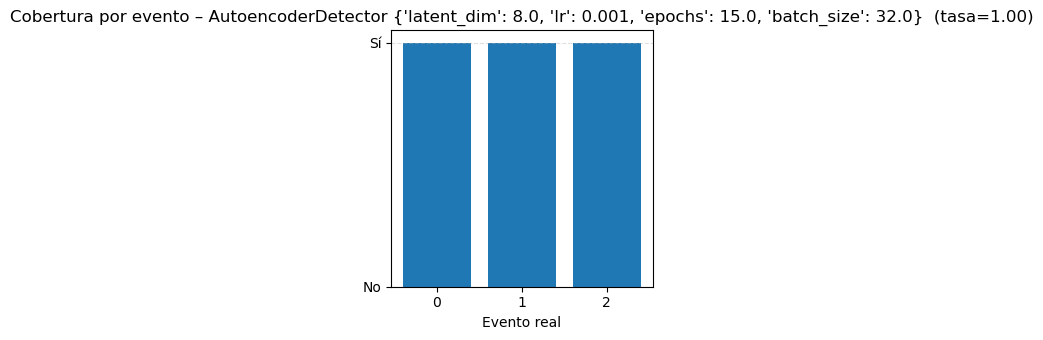

In [1]:
import warnings
warnings.filterwarnings("ignore", message="Cannot get CPU affinity")

from dask_cuda import LocalCUDACluster
from dask.distributed import Client, LocalCluster

# ‚ö° Cluster: CPU o GPU seg√∫n necesites
# cluster = LocalCluster()   # CPU
cluster = LocalCUDACluster()  # Si quieres GPU distribuida (cuando tengas varias)
client = Client(cluster)
print(client)

# Dashboard en http://127.0.0.1:8787

# ===================================================
# Experimento con Autoencoder
# ===================================================
from runner import run_dataset_experiment

from modelos.validation_metrics import (
    precision_metric, recall_metric, f1_metric,
    roc_auc_metric, nab_metric, window_coverage_metric
)

metrics = {
    "precision": precision_metric,
    "recall": recall_metric,
    "f1": f1_metric,
    "roc_auc": roc_auc_metric,
    "nab": nab_metric,
    "window_coverage": window_coverage_metric,
}

# --- Hiperpar√°metros del Autoencoder ---
param_grid = {          
    "latent_dim": [8],
    "lr": [1e-3],
    "epochs": [5],
    "batch_size": [32]
}

from modelos.AutoencoderDetector import AutoencoderDetector

df_results, topk, df_final = run_dataset_experiment(
    dataset_name="BATADAL",          # cambia por tu dataset
    model_class=AutoencoderDetector,
    param_grid=param_grid,
    metrics=metrics,
    params_cv={"num_windows": 3},    # n√∫mero de splits de validaci√≥n
    device="gpu",                    # "cpu" o "gpu" (si tienes 1 GPU, pon "gpu")
    mode="walkforward",                     # validaci√≥n con ventana expansiva
    hampel_cfg={"window": 100, "sigma": 5.0},
    top_k=5,
    sort_metric="nab",
    plot_mode="best"
)
